# Gradient Boosting Machine (GBM)


1. 모델 소개
Gradient Boosting Machine (GBM)은 Jerome H. Friedman이 제안한 앙상블 학습 기법으로, 여러 개의 약한 학습기(주로 결정 트리)를 순차적으로 학습시켜 이전 모델의 오류를 보완해 나가는 방식으로 강력한 예측 모델을 만듭니다. 부스팅 알고리즘을 특정 절차가 아닌, 함수 공간(Function Space)에서 손실 함수를 최적화하는 일반적인 프레임워크로 재해석하여 XGBoost, LightGBM과 같은 현대 부스팅 모델의 이론적 기틀을 마련했습니다.   

2. 주요 특징
함수 공간에서의 경사 하강법 (Gradient Descent in Function Space) GBM은 모델 학습 과정을 파라미터 최적화가 아닌 함수 최적화 문제로 접근합니다. 각 단계에서 손실 함수를 가장 가파르게 감소시키는 방향(Negative Gradient)으로 새로운 약한 학습기를 추가하는 방식을 사용합니다.   

유사 잔차 (Pseudo-Residuals) 새로운 약한 학습기는 이전 모델의 실제 잔차(Residual)가 아닌, 손실 함수의 그래디언트를 기반으로 계산된 '유사 잔차'를 학습 목표로 삼습니다. 이를 통해 제곱 오차(Squared Error) 외에 다른 다양한 손실 함수에도 부스팅을 적용할 수 있습니다.   

임의의 미분 가능한 손실 함수 (Arbitrary Differentiable Loss Functions) 미분만 가능하다면 어떤 손실 함수든 사용할 수 있어 높은 유연성을 가집니다. 이 덕분에 회귀, 분류 등 다양한 문제에 동일한 프레임워크를 적용할 수 있습니다.   

탐욕적 단계적 학습 (Greedy Stagewise Approach) 모델은 한 번에 하나의 약한 학습기를 순차적으로 추가하는 탐욕적(Greedy) 방식으로 구축됩니다. 각 단계에서는 이전에 추가된 학습기는 그대로 두고, 현재 모델의 성능을 가장 크게 개선하는 새로운 학습기만 찾습니다.   

3. 참고 자료
논문 제목: Greedy Function Approximation: A Gradient Boosting Machine    

저자: Jerome H. Friedman    

학회: The Annals of Statistics (2001)    

논문 링크: http://www.jstor.org/stable/2699986    



In [3]:
# library & install
from google.colab import drive
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
import sys
import os

# Specify the path to the directory containing data_load.py
# Make sure this path is correct and accessible from your Colab environment
data_load_path = '/content/drive/MyDrive/utils'

# Add the directory to sys.path to allow importing modules from it
sys.path.append(data_load_path)

try:
    # Import the data_load module
    import data_load

    # Now you can use functions from the data_load module, for example:
    # from data_load import your_function_name
    # your_function_name()

    print("Successfully imported data_load.py")

    # Call the load_data function inside the try block
    combined_df = data_load.load_data(start_date='2025-01-01', end_date='2025-09-14')


except ImportError as e:
    print(f"Error importing data_load.py: {e}")
    print(f"Please ensure data_load.py exists at {os.path.join(data_load_path, 'data_load.py')} and the file name is correct.")

Successfully imported data_load.py
🔍 ['2025-01-01'부터 '2025-09-14'까지의 데이터를 로드]


/content/drive/MyDrive/utils/data_load.py:48: DtypeWarning: Columns (19,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(
/content/drive/MyDrive/utils/data_load.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs_to_concat, ignore_index=True)



✅ 총 257개 파일, 8474140개 행의 데이터를 성공적으로 합쳤습니다.


In [5]:
# Specify the path to the directory containing preprocessor.py
# Make sure this path is correct and accessible from your Colab environment
preprocessor_path = '/content/drive/MyDrive/utils'

# Add the directory to sys.path to allow importing modules from it
sys.path.append(preprocessor_path)

try:
    # Import the preprocessor module
    import preprocessor

    print("Successfully imported preprocessor.py")

except ImportError as e:
    print(f"Error importing preprocessor.py: {e}")
    print(f"Please ensure preprocessor.py exists at {os.path.join(preprocessor_path, 'preprocessor.py')} and the file name is correct.")

Successfully imported preprocessor.py


In [6]:
# Identify columns that are currently of object type
object_cols = combined_df.select_dtypes(include=['object']).columns

# Convert all values in object columns to string type to ensure uniform input for potential LabelEncoding within preprocessor.py
for col in object_cols:
    combined_df[col] = combined_df[col].astype(str)
    print(f"✅ 컬럼 '{col}'을(를) 문자열 타입으로 변환 완료")

combined_df = preprocessor.preprocessor(combined_df)



✅ 컬럼 '생성일'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '급수펌프 입력'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기가스온도2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기가스온도3'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '배기 재 순환 온도'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '에코 온도1'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '에코 온도2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '버너온도'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '재순환 O2'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '재순환 NOx'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '운전시간'을(를) 문자열 타입으로 변환 완료
✅ 컬럼 '확률 업데이트 시간'을(를) 문자열 타입으로 변환 완료
--- 데이터 전처리 시작 ---
✅ 1. 불필요한 컬럼 14개 제거 완료
✅ 2. '효율(순간)' 컬럼 값 100 미만으로 필터링 완료
✅ 3-1. 범주형 데이터 결측치 처리 완료
✅ 3-2. 범주형 변수 변환 완료
ℹ️ 3-3. 처리할 수치형 결측치가 없습니다.
✅ 4. 피처 스케일링 완료
--- 데이터 전처리 완료 ---


In [2]:
!sudo apt-get -qq install fonts-nanum

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# Fix broken Korean fonts
import matplotlib as mpl
import matplotlib.font_manager as fm
from pathlib import Path

# ① Set the path to the installed font file (change to the path verified by fc-list)
font_path_candidates = [
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",                 # Nanum Gothic
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",          # Noto CJK (opentype)
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",          # Noto CJK (truetype)
]
font_path = next((p for p in font_path_candidates if Path(p).exists()), None)
assert font_path is not None, "Font file not found. Please verify the path with fc-list and update font_path."

# ② Register the font file directly with Matplotlib
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

# ③ Set as global default font + prevent minus sign issues
mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False

In [7]:
# separate features and target
y_col = '효율(순간)'
X = combined_df.drop(columns=[y_col])
y = combined_df[y_col]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
from sklearn.model_selection import RandomizedSearchCV
# 하이퍼파라미터 튜닝 (RandomizedSearchCV)
if 'X_train' in locals() and X_train is not None:
    print("\n--- 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---")
    # Gradient Boosting 모델 초기화
    gbm_model = GradientBoostingRegressor(random_state=42)

    # 파라미터 분포 설정
    param_dist = {
        'n_estimators': np.arange(50, 501, 50), # 50 ~ 500, 50 간격
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': np.arange(3, 11), # 3 ~ 10
        'subsample': np.arange(0.6, 1.01, 0.1), # 0.6 ~ 1.0, 0.1 간격
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5]
    }

    # Randomized Search 설정
    # n_iter 값을 줄이면 탐색 시간이 단축됩니다 (예: 50 또는 30)
    # cv 값을 줄여도 시간이 단축됩니다 (예: 3)
    n_iterations = 10 # 시도할 조합 수 (시간에 따라 조절)
    cv_folds = 2 # 교차 검증 폴드 수 (시간에 따라 조절)

    random_search = RandomizedSearchCV(
        gbm_model,
        param_distributions=param_dist,
        n_iter=n_iterations,
        scoring='neg_mean_squared_error', # MSE 기준으로 최적화 (낮을수록 좋음)
        cv=cv_folds,
        verbose=1,
        random_state=42,
        n_jobs=-1 # 모든 CPU 코어 사용
    )

    # Randomized Search 실행
    try:
        random_search.fit(X_train, y_train)
        best_params_gbm = random_search.best_params_
        print("\n✅ 하이퍼파라미터 튜닝 완료")
        print("최적 하이퍼파라미터:", best_params_gbm)
    except Exception as e:
        print(f"❌ 하이퍼파라미터 튜닝 중 오류 발생: {e}")
        best_params_gbm = None # 오류 시 None으로 설정
else:
    print("ℹ️ 학습 데이터가 없어 하이퍼파라미터 튜닝을 건너뜁니다.")



--- 하이퍼파라미터 튜닝 시작 (RandomizedSearchCV) ---
Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



✅ 하이퍼파라미터 튜닝 완료
최적 하이퍼파라미터: {'subsample': np.float64(0.6), 'n_estimators': np.int64(500), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': np.int64(6), 'learning_rate': 0.2}



--- 최적 파라미터로 모델 학습 및 평가 시작 ---
✅ 모델 학습 완료
✅ 예측 수행 완료

--- 모델 평가 결과 ---
Train R2: 0.999964
Test R2 : 0.999958
Train MSE: 0.000036
Test MSE : 0.000042
Train MAE: 0.003246
Test MAE : 0.003312
Train RMSE: 0.005966
Test RMSE : 0.006474
Train MAPE: 2.8864%
Test MAPE : 2.7537%
Train Accuracy (Rounded): 0.996984
Test Accuracy (Rounded) : 0.996934

--- 특성 중요도 확인 ---
상위 10개 특성 중요도:
         feature  importance
29     급수량(순간유량)    0.971316
31     연료량(순간유량)    0.026681
8       가스 댐퍼 입력    0.001013
16        보일러 온도    0.000397
19       배기가스온도3    0.000184
25       배기가스 O2    0.000175
21        에코 온도1    0.000097
11        재순환 댐퍼    0.000064
13     재순환 댐퍼 입력    0.000018
14  재순환 외기 댐퍼 입력    0.000013


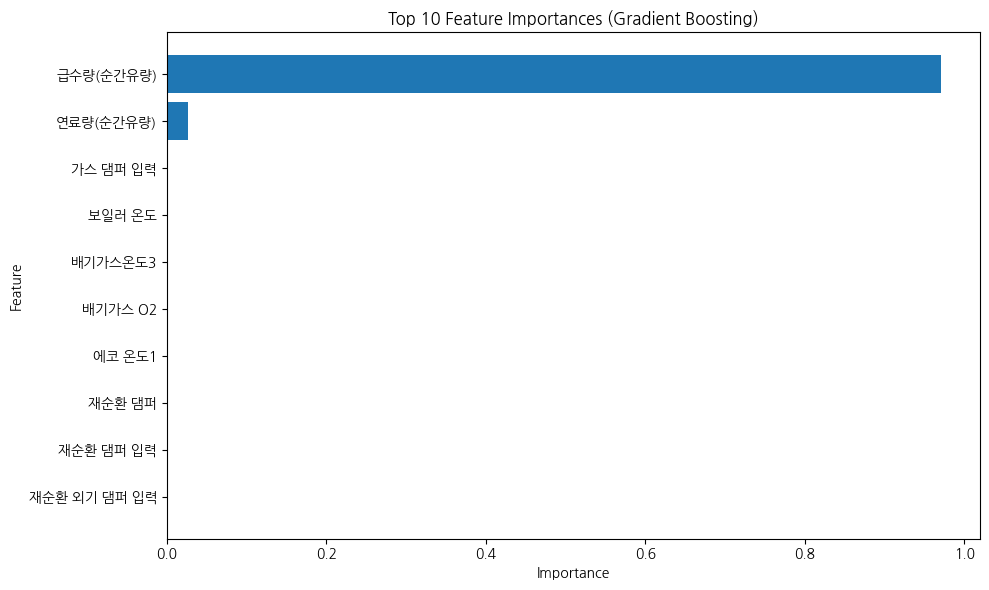


--- 모든 작업 완료 ---


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_absolute_percentage_error
# 최적 파라미터로 모델 학습 및 평가
if 'best_params_gbm' in locals() and best_params_gbm is not None and X_train is not None:
    print("\n--- 최적 파라미터로 모델 학습 및 평가 시작 ---")
    # 최적 파라미터로 모델 초기화
    gbm_final_model = GradientBoostingRegressor(
        **best_params_gbm,
        random_state=42
    )

    # 모델 학습
    try:
        gbm_final_model.fit(X_train, y_train)
        print("✅ 모델 학습 완료")

        # 예측 수행
        y_train_pred_gbm = gbm_final_model.predict(X_train)
        y_test_pred_gbm = gbm_final_model.predict(X_test)
        print("✅ 예측 수행 완료")

        # 평가 지표 계산
        train_r2 = r2_score(y_train, y_train_pred_gbm)
        test_r2 = r2_score(y_test, y_test_pred_gbm)
        train_mse = mean_squared_error(y_train, y_train_pred_gbm)
        test_mse = mean_squared_error(y_test, y_test_pred_gbm)
        train_mae = mean_absolute_error(y_train, y_train_pred_gbm)
        test_mae = mean_absolute_error(y_test, y_test_pred_gbm)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)

        # MAPE 계산 함수 (0으로 나누기 방지)
        def mean_absolute_percentage_error(y_true, y_pred):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            non_zero_mask = y_true != 0
            if np.sum(non_zero_mask) == 0: return np.nan
            return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

        train_mape = mean_absolute_percentage_error(y_train, y_train_pred_gbm)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred_gbm)


        train_accuracy = accuracy_score(np.round(y_train), np.round(y_train_pred_gbm))
        test_accuracy = accuracy_score(np.round(y_test), np.round(y_test_pred_gbm))


        # 결과 출력
        print("\n--- 모델 평가 결과 ---")
        print(f"Train R2: {train_r2:.6f}")
        print(f"Test R2 : {test_r2:.6f}")
        print(f"Train MSE: {train_mse:.6f}")
        print(f"Test MSE : {test_mse:.6f}")
        print(f"Train MAE: {train_mae:.6f}")
        print(f"Test MAE : {test_mae:.6f}")
        print(f"Train RMSE: {train_rmse:.6f}")
        print(f"Test RMSE : {test_rmse:.6f}")
        print(f"Train MAPE: {train_mape:.4f}%")
        print(f"Test MAPE : {test_mape:.4f}%")
        print(f"Train Accuracy (Rounded): {train_accuracy:.6f}") # 정확도 출력 추가
        print(f"Test Accuracy (Rounded) : {test_accuracy:.6f}")  # 정확도 출력 추가


    except Exception as e:
        print(f"❌ 모델 학습 또는 평가 중 오류 발생: {e}")

else:
    print("ℹ️ 최적 파라미터가 없거나 학습 데이터가 없어 모델 학습 및 평가를 건너뜁니다.")


# 특성 중요도 확인 및 시각화
if 'gbm_final_model' in locals() and 'X_train' in locals() and X_train is not None:
    print("\n--- 특성 중요도 확인 ---")
    try:
        importances = gbm_final_model.feature_importances_
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        print("상위 10개 특성 중요도:")
        print(feature_importance_df.head(10))

        # 특성 중요도 시각화 (상위 10개)
        plt.figure(figsize=(10, 6))
        top_n = 10
        plt.barh(feature_importance_df['feature'][:top_n][::-1], feature_importance_df['importance'][:top_n][::-1])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Top {top_n} Feature Importances (Gradient Boosting)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ 특성 중요도 확인 또는 시각화 중 오류 발생: {e}")
else:
    print("ℹ️ 학습된 모델 또는 학습 데이터가 없어 특성 중요도 확인을 건너뜁니다.")

print("\n--- 모든 작업 완료 ---")